In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
import os
print(os.listdir('.'))
train = pd.read_csv('input2/train.csv')
test = pd.read_csv('input2/test.csv')

all_data = pd.concat((train, test), axis=0, sort=False).reset_index(drop=True)

['.ipynb_checkpoints', 'Analise_Variavel_Alley.ipynb', 'Analise_Variavel_MiscFeature.ipynb', 'Analise_Variavel_Qualidade_Piscina.ipynb', 'HousePriceV012-20200414.ipynb', 'input2']


In [56]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [33]:
"""SOLUÇÃO MISSING PISCINA
1 - PoolQC referesse a qualidade da piscina nitidamente deve ser uma variável ordinal.
1.1 Todos os valores que não tem PoolArea e PoolQC praticamente coincidem. Ou seja, todos os valores PoolQC não informados
e que também não tem PoolArea são porque não tem piscina. A maioria da base tem essa característica.
1.2 Como são poucos registros com PoolQC informados em relação ao total adotar a distância de 1 entre as classificações 
será um bom critério. Tem somente 8 registros com SalePrice e como a correlação não é forte não parece razoável 
ponderar esses valores pelo SalePrice.
2.1 a analise do histograma para PoolQC mostrou que a mediana e a média apresentaram o mesmo valor 4.
2.2 Aqui cabe uma reflexão, esses valores que estavam vazios e tinham area fazem parte do BD teste e não tinham valor para 
variável target. 
2.3 Analise correlação entre PoolArea e PoolQC e SalePrice
2.3.1 Como se trata de uma variável categórica ordinal a analise de correlação pode ser feita pelo ANOVA. No qual compara-se
a média de preço para os grupos e verifica se existe correlação.

Interessante no treinamento adotar abordagens:
1 - Fazer simulação adotando valores ordinais crescentes conforme a qualidade. E os itens sem classificação que tem PoolArea
e não tem classificação adotar o valor zero. Talvez possa representar o fato de ter a area para piscina e não ter a piscina.

2 - Fazer simulação adotando valores ordinais crescentes conforme a qualidade. E os itens sem classificação que tem PoolArea
e não tem classificação adotar o valor medio. Assim, tratando como um erro de classificação os registros não classificados
devem interferir menos na predição.

3 - Já que existe uma correlação (mesmo fraca) entre SalePrice e PoolQC	adotar o Target encoding. Apontar os valores do
desvio padrão do target conforme correlação com a variável alvo. *** cuidado com overfitting.

4- Utiliza a correlação entre o item 3 mas proporcionaliza também considerando o ranking entre as variáveis.

5- O algoritmo xboost aceita variavel null uma opção é deixar para verificar performance do algoritmo
"""

In [ ]:
""" 
tecnica para o item 1
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)

all_data.loc[(all_data['PoolArea'] > 0) & (all_data['PoolQC'].isnull()), 'PoolQC'] = 0



tecnica para o item 2
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)

all_data.loc[(all_data['PoolArea'] > 0) & (all_data['PoolQC'].isnull()), 'PoolQC'] = all_data[~all_data['PoolQC'].isnull() ]['PoolQC'].median()
"""

In [158]:
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)
dbfilter = all_data[(all_data['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()) & (~all_data['SalePrice'].isnull())]

dbfilter[['PoolArea','PoolQC', 'SalePrice']].sort_values(['PoolArea'], ascending=False)
mean_encode = dbfilter.groupby('PoolQC')['SalePrice'].std()
all_data['PoolQC'] = dbfilter['PoolQC'].map(mean_encode)
all_data.loc[(all_data['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC'] = all_data.loc[(all_data['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC'] * (dbfilter['PoolQC'] / dbfilter['PoolQC'].sum())
# as piscinas sem qualidade mais com area foi atribuido o desvio padrao da variavel target para todos os PoolQC classificados
all_data.loc[all_data['PoolQC'].isnull() & (all_data['PoolArea'] > 0), 'PoolQC'] = dbfilter['SalePrice'].std()
#aos demais itens sem area e sem qualidade piscina o campo qualidade foi atribuido 0
all_data['PoolQC'] = all_data['PoolQC'].fillna(0)

In [49]:
dbfilter = all_data[~all_data['PoolQC'].isnull() & (~all_data['SalePrice'].isnull())][['PoolQC','SalePrice']]
#dbfilter[['PoolArea','PoolQC', 'SalePrice']].sort_values(['PoolArea'], ascending=False)
dbfilter

,PoolQC,SalePrice
197,Ex,235000.0
810,Fa,181000.0
1170,Gd,171000.0
1182,Ex,745000.0
1298,Gd,160000.0
1386,Fa,250000.0
1423,Gd,274970.0


In [52]:
grouped_anova = dbfilter.groupby(["PoolQC"])
anova_results = stats.f_oneway(grouped_anova.get_group("Ex")['SalePrice'],grouped_anova.get_group("Fa")['SalePrice'])

In [53]:
anova_results
# o resultado p>0.05 não é estatisticamente significante. e o F é um número pequeno que também torna ruim a predição.

F_onewayResult(statistic=1.1379591559346223, pvalue=0.39780146588456455)

In [24]:
list(grouped_anova)

[('Ex',
       PoolQC  SalePrice
  197      Ex   235000.0
  1182     Ex   745000.0),
 ('Fa',
       PoolQC  SalePrice
  810      Fa   181000.0
  1386     Fa   250000.0),
 ('Gd',
       PoolQC  SalePrice
  1170     Gd   171000.0
  1298     Gd   160000.0
  1423     Gd   274970.0)]

In [115]:
novodb = (dbfilter.loc[(dbfilter['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC']/ dbfilter.loc[(dbfilter['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC'].sum()) 
dbfilter['PoolQC'].map(mean_encode)

197     360624.458405
810      48790.367902
1170     63441.392639
1182    360624.458405
1298     63441.392639
1386     48790.367902
1423     63441.392639
Name: PoolQC, dtype: float64

In [137]:
all_data.loc[all_data['PoolQC'].isnull() & (all_data['PoolArea'] > 0)]['PoolQC'] = dbfilter['SalePrice'].std()

1974   NaN
2420   NaN
2503   NaN
2573   NaN
2599   NaN
2710   NaN
Name: PoolQC, dtype: float64

,SalePrice
SalePrice,1.0


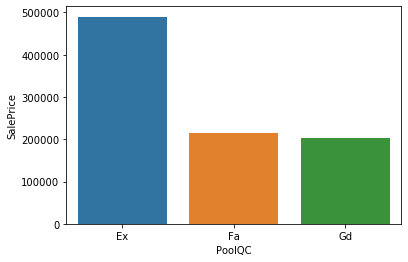

In [54]:
grafico = dbfilter.groupby('PoolQC')['SalePrice'].mean().to_frame(name = 'SalePrice').reset_index()
grafico
sns.barplot(data=grafico,x='PoolQC', y='SalePrice')
grafico.corr(method='kendall')

In [58]:
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)
all_data['PoolQC'] = all_data['PoolQC'].fillna(0)

In [74]:
dbanalise = all_data[(all_data['PoolQC'] >0) & (all_data['SalePrice'] >0)][['PoolQC', 'SalePrice']]
all_data[(all_data['PoolQC'] >0) & (all_data['SalePrice'] >0)][['PoolQC', 'SalePrice']].corr()

,PoolQC,SalePrice
PoolQC,1.000000,0.447936
SalePrice,0.447936,1.000000


In [81]:
dbanalise = all_data[['PoolQC', 'SalePrice']]

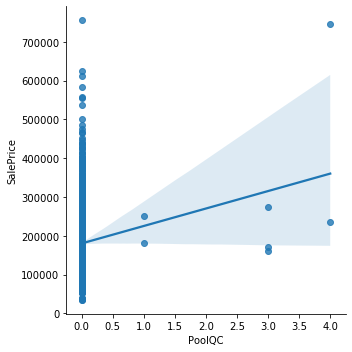

In [82]:
sns.lmplot(x='PoolQC',y='SalePrice',data=dbanalise)

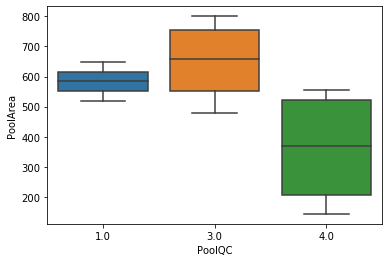

In [39]:
sns.boxplot(x='PoolQC',y='PoolArea',data=dbfilter)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024AE7084C70>,
      dtype=object)

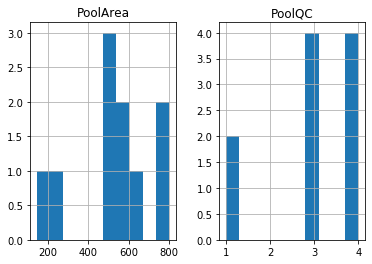

In [41]:
dbfilter[['PoolArea','PoolQC']].hist()

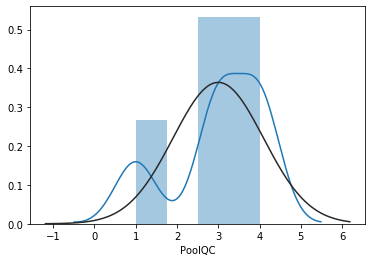

In [44]:
sns.distplot(dbfilter['PoolQC'] , fit=norm);